# Generate stratified panels by week, machine using preprocessed domains data: Using census race data

Multiple panels are generated for each week of data by using a random stratified sampling process.

The preprocessed sessions/domains data is used so that panels only include samples with sufficient data.

Panels are sampled using stratified random sampling (without replacement) so that the distribution of race demographics in each of the panels matches the distribution of the U.S. population, as reported by the Census (ACS).

In [1]:
from datetime import datetime
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Retrieving census data



We looked up the census ACS codes from [here](https://api.census.gov/data/2017/acs/acs5/profile/variables.html) and made the following mapping between ACS and comscore data values.

In [2]:
from census import Census
import us


# ACS_YEAR = 2017 
ACS_YEAR = 2019 # <-- most recent year of data available
c = Census("14a343e581b5dd1df551f4cd87f31aede50ec908", year=ACS_YEAR)

census_comscore_race_mapping = pd.DataFrame([
    # ComScore uses 1,2,3,5
    # e.g. instead use DP05_0037PE
    ['DP05_0077PE', 1, 'non-hispanic white'], 
    ['DP05_0078PE', 2, 'non-hispanic black'],
    ['DP05_0080PE', 3, 'non-hispanic asian'],
    # ComScore 5: other
], columns=['census_code', 'comscore_code', 'description'])

# API call to get the values
census_comscore_race_mapping['value'] = census_comscore_race_mapping.census_code.map(
    c.acs5dp.us(list(census_comscore_race_mapping.census_code.values))[0]
)/100
# add in 'other'
census_comscore_race_mapping = census_comscore_race_mapping.append({
    'comscore_code': 5,
    'description': 'other',
    'value': 1 - census_comscore_race_mapping.value.sum(),
}, ignore_index=True)

assert(census_comscore_race_mapping.value.sum() == 1) # percentage values should add up to 1
census_comscore_race_mapping


,census_code,comscore_code,description,value
0,DP05_0077PE,1,non-hispanic white,0.607
1,DP05_0078PE,2,non-hispanic black,0.123
2,DP05_0080PE,3,non-hispanic asian,0.055
3,NaN,5,other,0.215


## Create comscore sampling frame

In [3]:
COMSCORE_YEAR=2017

print("Reading comscore demographics data...")

def read_comscore_demo_df(fpath):
    demo_df = (pd.read_csv(fpath, usecols=['racial_background', 'machine_id'])
               .replace({99:np.nan, -88: np.nan})
              .dropna())
    return demo_df

comscore_demo_df = read_comscore_demo_df(
    fpath='../data/comscore/2017/demographics.csv'.format(year=COMSCORE_YEAR)
)
comscore_demo_df.head()

Reading comscore demographics data...


,machine_id,racial_background
0,46569906.0,1.0
1,70298839.0,1.0
2,76984170.0,1.0
3,76991725.0,1.0
5,81191519.0,1.0


we create stratified samples where the sampling frame is limited to (machine, week) pairs with at least the threshold number of domains (7 domains for FLoC OT implementation)

In [4]:
from comscore.data import read_weeks_machines_domains


weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'

weeks_machines_domains_df = read_weeks_machines_domains(
    weeks_machines_domains_fpath
).drop('domains', axis=1) # do not need domains for panel creation, just week and n_domains

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


In [5]:
weeks_machines_domains_df.head()

,machine_id,week,n_domains
0,169007206,1,104
1,170331223,1,0
2,170422065,1,20
3,170911221,1,49
4,171771316,1,64


In [6]:
N_DOMAINS_THRESHOLD = 7

comscore_sampling_frame_df = (
    weeks_machines_domains_df[weeks_machines_domains_df.n_domains >= N_DOMAINS_THRESHOLD]
    .merge(comscore_demo_df, 
               how='inner', # only include machine_ids with valid data (no nan race)
               left_on='machine_id', 
               right_on='machine_id')
      
)
print('%s rows for sampling frame' % len(comscore_sampling_frame_df))
assert(len(comscore_sampling_frame_df)==len(comscore_sampling_frame_df.dropna()))

comscore_sampling_frame_df.head()

2073354 rows for sampling frame


,machine_id,week,n_domains,racial_background
0,169007206,1,104,2.0
1,169007206,2,78,2.0
2,169007206,3,77,2.0
3,169007206,4,53,2.0
4,169007206,5,47,2.0


When assuming 1 (white) is non-hispanic white, sampling frame demographics are not so different from U.S. demographics.
We stratify anyhow.

In [13]:
comscore_sampling_frame_values = (
    comscore_sampling_frame_df.racial_background.value_counts()/len(comscore_sampling_frame_df)
)
print(comscore_sampling_frame_values.sort_index())
assert(comscore_sampling_frame_values.sum()==1)

1.0    0.643025
2.0    0.153411
3.0    0.073222
5.0    0.130341
Name: racial_background, dtype: float64


In [14]:
census_comscore_race_mapping.set_index('comscore_code')['value']

comscore_code
1    0.607
2    0.123
3    0.055
5    0.215
Name: value, dtype: object

## Generate the panels via stratified random sampling without replacement

In [19]:
import random


def stratify_data_without_replacement(
    df_data,
    stratify_column_name,
    stratify_values,
    stratify_proportions,
    random_state=None,
):
    df_stratified = pd.DataFrame(columns=df_data.columns)
    # base the panel size on the most underrepresented strata
    min_idx = np.argmin(df_data.groupby('stratify').size().values/stratify_proportions) # np.argmax(stratify_proportions)
    max_N = len(df_data[df_data[stratify_column_name] == stratify_values[min_idx]])
    true_N = (stratify_proportions / stratify_proportions[min_idx]) * max_N
    for i, N in enumerate(true_N):
        df_resampled = df_data[
            df_data[stratify_column_name] == stratify_values[i]
        ].sample(replace=False, n=int(N), random_state=random_state)
        df_stratified = pd.concat([df_stratified, df_resampled])
    return df_stratified


def generate_weekly_stratified_samples(census_comscore_race_mapping, 
                                       comscore_sampling_frame_df, 
                                       random_seed=datetime.now()):
    """
    Creates a randomly stratified panel for each week of comscore data.
    stratification is on the distribution of racial background reported by
    census (ACS) data.
    
    args:
    
    census_values_df a mapping of racial_
    
    comscore_sampling_frame_df is a table with columns
        machine_id, week, household_income, racial_background
        where the data has been limited to a sampling frame with valid data
    """
    random.seed(random_seed)
    census_stratify = census_comscore_race_mapping.set_index('comscore_code')['value']
    comscore_sampling_frame_df['stratify'] = (
        comscore_sampling_frame_df.racial_background.astype(int)
    )
    weekly_panels = []
    for week in comscore_sampling_frame_df.week.unique():
        comscore_week_df = comscore_sampling_frame_df[comscore_sampling_frame_df.week == week]
        demo_df_s = stratify_data_without_replacement(
            comscore_week_df, "stratify", 
            census_comscore_race_mapping['comscore_code'].astype(int),
            census_comscore_race_mapping['value']
        )
        weekly_panels.append(demo_df_s)
    return pd.concat(weekly_panels)

In [20]:
N_WEEKLY_PANELS = 10
all_panels = []
for p in range(N_WEEKLY_PANELS):
    print('%s/%s: generating weekly panels' % (p + 1, N_WEEKLY_PANELS))
    # each call returns 52 panels representing 1 week
    panel_weeks = generate_weekly_stratified_samples(census_comscore_race_mapping, 
                                                     comscore_sampling_frame_df)
    panel_weeks['panel_id'] = panel_weeks.week + p * 52
    all_panels.append(panel_weeks)

1/10: generating weekly panels
2/10: generating weekly panels
3/10: generating weekly panels
4/10: generating weekly panels
5/10: generating weekly panels
6/10: generating weekly panels
7/10: generating weekly panels
8/10: generating weekly panels
9/10: generating weekly panels
10/10: generating weekly panels


In [21]:
all_panels_df = pd.concat(all_panels).reset_index(drop=True)
all_panels_df.head()

,machine_id,week,n_domains,racial_background,stratify,panel_id
0,216368766,1,76,1.0,1,1
1,225562713,1,22,1.0,1,1
2,193448730,1,209,1.0,1,1
3,216306558,1,17,1.0,1,1
4,223440886,1,7,1.0,1,1


Check we did this right...

In [22]:
assert(all_panels_df.week.nunique()==52)
print('sampling frame size for week 1: %s' % (
    len(comscore_sampling_frame_df[comscore_sampling_frame_df.week==1])))
print('panel size for panel 1 (week 1): %s' % len(all_panels_df[all_panels_df.panel_id==1]))

sampling frame size for week 1: 42012
panel size for panel 1 (week 1): 25900


In [25]:
panel_id = 1
all_panels_df[all_panels_df.panel_id==panel_id].head()

,machine_id,week,n_domains,racial_background,stratify,panel_id
0,216368766,1,76,1.0,1,1
1,225562713,1,22,1.0,1,1
2,193448730,1,209,1.0,1,1
3,216306558,1,17,1.0,1,1
4,223440886,1,7,1.0,1,1


In [26]:
panel_id = 53
all_panels_df[all_panels_df.panel_id==panel_id].head()

,machine_id,week,n_domains,racial_background,stratify,panel_id
1256874,218317749,1,8,1.0,1,53
1256875,191198278,1,19,1.0,1,53
1256876,231219665,1,37,1.0,1,53
1256877,203011830,1,14,1.0,1,53
1256878,228051452,1,15,1.0,1,53


In [23]:
all_panels_df.groupby('racial_background').size()/len(all_panels_df)

racial_background
1.0    0.607017
2.0    0.122988
3.0    0.054982
5.0    0.215013
dtype: float64

In [27]:
census_comscore_race_mapping

,census_code,comscore_code,description,value
0,DP05_0077PE,1,non-hispanic white,0.607
1,DP05_0078PE,2,non-hispanic black,0.123
2,DP05_0080PE,3,non-hispanic asian,0.055
3,NaN,5,other,0.215


### Save the panels to file

In [28]:
comscore_acs_race_panels_fpath = '../output/comscore_acs_race_panels.csv'

In [29]:
print('saving all panels to file %s ...' % comscore_acs_race_panels_fpath)
all_panels_df.to_csv(comscore_acs_race_panels_fpath, index=False)
print('... saved')

saving all panels to file ../output/comscore_acs_race_panels.csv ...
... saved


### Panel testing

Read panel again

In [30]:
all_panels_df = pd.read_csv(comscore_acs_race_panels_fpath)

Sanity checks that we did this right:

In [31]:
print('all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.head()

all panels: 12568740 total rows
520 panels


,machine_id,week,n_domains,racial_background,stratify,panel_id
0,216368766,1,76,1.0,1,1
1,225562713,1,22,1.0,1,1
2,193448730,1,209,1.0,1,1
3,216306558,1,17,1.0,1,1
4,223440886,1,7,1.0,1,1


Note that not all panels are the same size because they are sampled by week, and each week in the sampling frame has a slightly different set of users.
But we should at least expect panels for the same week to be the same size.

In [32]:
# assert all panels for the same week have the same size
week_panel_id_counts = all_panels_df.groupby('week')['panel_id'].value_counts().rename('count')
for week in all_panels_df.week.unique():
    assert(week_panel_id_counts.xs(week).nunique() == 1)

week_panel_id_counts

week  panel_id
1     1           25900
      53          25900
      105         25900
      157         25900
      209         25900
                  ...  
52    312         21194
      364         21194
      416         21194
      468         21194
      520         21194
Name: count, Length: 520, dtype: int64

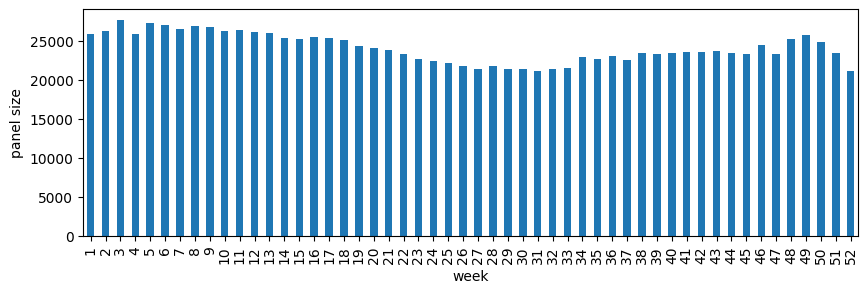

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=100)
week_panel_id_counts.to_frame().reset_index().drop_duplicates(
    subset=['week']
).set_index('week')['count'].plot.bar(ax=ax)
_ = ax.set_ylabel('panel size')

Check the demographics distributions are correct

In [34]:
race_values = {1:'white', 2:'black', 3:'asian', 5:'other'}

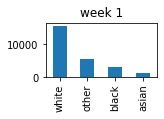

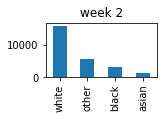

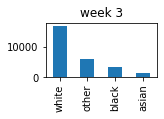

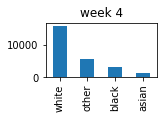

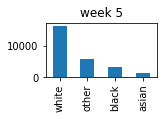

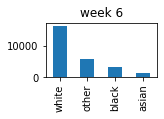

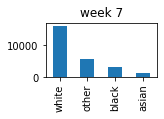

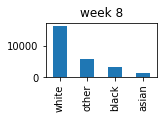

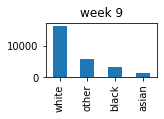

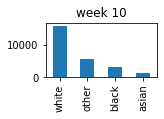

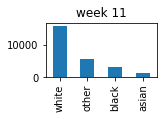

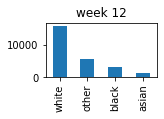

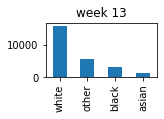

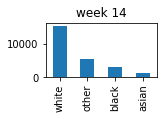

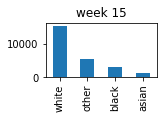

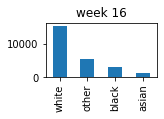

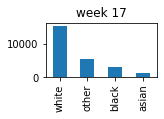

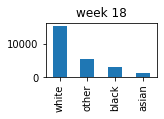

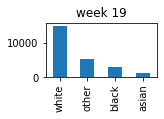

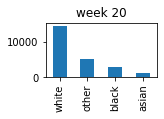

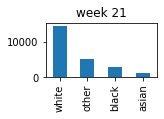

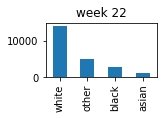

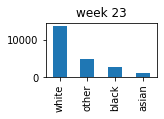

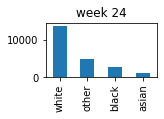

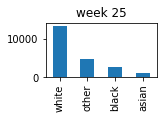

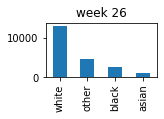

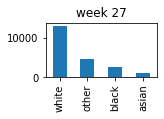

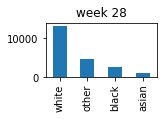

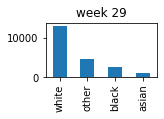

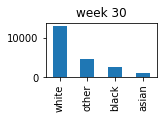

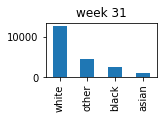

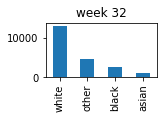

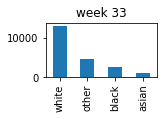

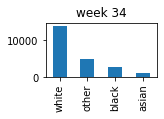

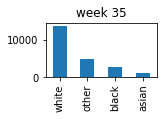

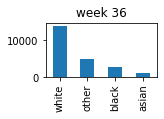

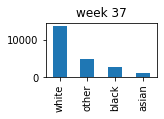

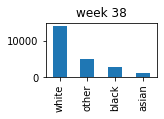

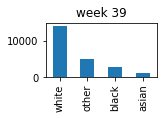

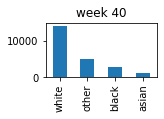

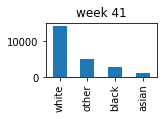

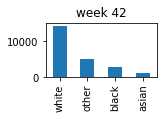

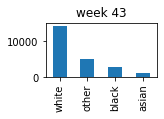

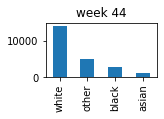

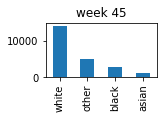

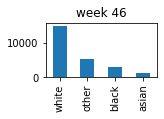

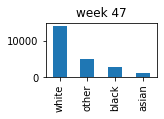

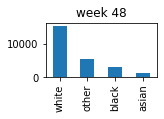

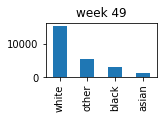

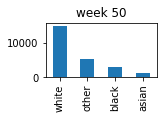

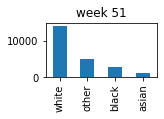

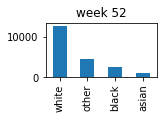

In [35]:
for week in all_panels_df.week.unique():
    week_df = all_panels_df[all_panels_df.week == week].copy()
    week_df.racial_background = week_df.racial_background.map(race_values)
    fig,ax = plt.subplots(1,1, figsize=(2,1))
    for panel_id in week_df.panel_id.unique():
        panel_week_df = week_df[week_df.panel_id == panel_id]
        race = panel_week_df.racial_background.value_counts().plot.bar(ax=ax)
    ax.set_title('week %s' % week)
    plt.show()